<a href="https://colab.research.google.com/github/madxox/SE_22/blob/master/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification

In this assignment you will learn how to build a simple neural network which will learn how to distinguish numbers between 0 and 9.
You will get to know the first hyperparameters which effect learning the neural network like the learning rate or the size of the neural network.

Let's begin with downloading the MNIST dataset: The most common datasets are available through the torchvision library.

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
import os
from tqdm import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import MNIST
mnist_dataset = MNIST(root='data', download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.31MB/s]


Lets investigate the dataset. The dataset consists of tuples containing an image of a number and the number it displays. We refer to this number as the ground truth value or label.

**Task 1 (1pts):** Investigate the dataset: First print the size of the dataset. Afterwards get the first element of the dataset and investigate what is contains. Plot the image as well as the corresponding ground truth.

In [2]:
#Investigate the dataset here.
print("Size of dataset:", len(mnist_dataset))
print(mnist_dataset[0])
image, label = mnist_dataset[0]
print("Ground truth: ", label)

Size of dataset: 60000
(<PIL.Image.Image image mode=L size=28x28 at 0x7BD3DA461910>, 5)
Ground truth:  5


As we can see the dataset contains 60000 images of numbers between 0 and 9. We can display an image:

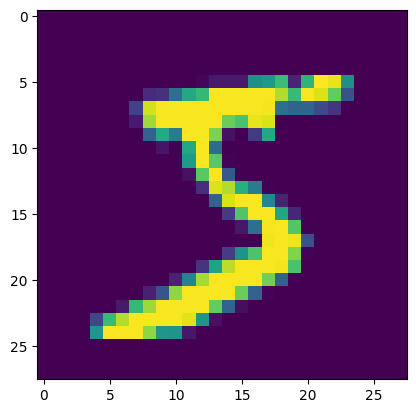

In [3]:
#plot the image here

plt.imshow(image)

As we can see torchvision has downloaded the dataset and saved it in the folder "./data/". In addition to that it constructed a pytorch dataset and we can get the size of the dataset or we can retrieve the image at a certain position just like in a numpy array. The __pytorch Dataset__ is useful to organize and iterate over our data, as well to separate the data preprocessing pipeline like smoothing data or removing outliers from the actual training pipeline. It consists of three class methods: the constructor of a class instance `__init__`, the `__getitem__` magic method, which allows you to index the dataset like an array with the []-operator and the `__len__`-method, which should return the length of the dataset. Here you can look up everything again: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

**Task 2 (8pts):** Write your own Dataset class with the skeleton provided below. Inspect the data organization in "./mnist_png/training" first. The dataset should not store the entire MNIST dataset at once, but should "lazy loading" an image per indexing (`__getitem__`). The length of the dataset should be the number of images contained in the training dataset. Download the mnist_png zip-file and store it your directory. Use the corresponding path as `path_to_data`.


**Task 3 (1pts):** We need a Dataset for training and we need a dataset for testing or validating. How can be easily create one Dataset instance which is useful for every setting? Hint: Take a look how the data is organized on your disk and how you could easily switch between the paths for "training" and "testing". You only have to alter the constructor.

60000
0 255


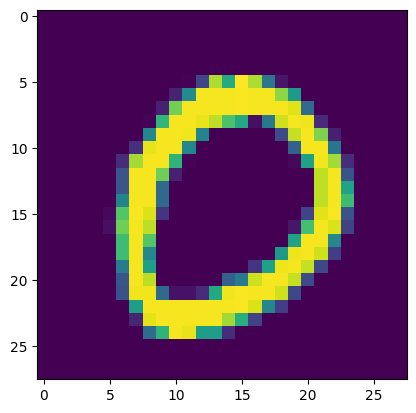

In [7]:
import zipfile # working with zipfile of the mnist_png folder, since my laptop could not handle extracting the folder...
import os
from PIL import Image
import io
import numpy as np

class MNISTDataset(Dataset):
    def __init__(self, path_to_data, training_data=True):
      # insert code here
      self.images = []
      self.labels = []
      self.path_to_data = path_to_data

      # Task 3: Based on the training data param we can switch via boolean if we want training or test data
      with zipfile.ZipFile(path_to_data, "r") as zip_ref:
          if training_data:
              data_dir = "mnist_png/training/"
          else:
              data_dir = "mnist_png/testing/"

      for label in range(10):
            label_dir = os.path.join(data_dir, str(label))
            for img_name in zip_ref.namelist():
                if img_name.startswith(label_dir) and img_name.endswith('.png'):
                    self.images.append(img_name)
                    self.labels.append(label)

        # e.g path to the data, different classes, number of images per class, or image IDs per class

    def __getitem__(self, idx):
        # insert code here
        img, label = self.images[idx], self.labels[idx]
        with zipfile.ZipFile(self.path_to_data, "r") as zip_ref:
            img_data = zip_ref.read(img)
            img = Image.open(io.BytesIO(img_data)).convert('L')
            img = np.array(img)
        # returning a single image per given index idx and its corresponding label
        return img, label

    def __len__(self):
      # insert code here
      # returning whole length of the dataset / number of images
      return len(self.labels)


mnist_dataset = MNISTDataset("./mnist_png.zip")
img_label_pair = mnist_dataset[0]
img = img_label_pair[0]
print(len(mnist_dataset))
print(img.min(), img.max())
plt.imshow(img)

Now we created our own dataset. You recognized that we dont load every image at once, but only one image per call. For large datasets and especially in medical imaging where images can be very large, this is more efficient as it is faster and allocates less space.

Lets get to the definition of the neural network. There are several options how to create a neural network in pytorch.
You can create your model as own class inheriting from a __torch.nn.Module__ or you use the class __torch.nn.Sequential__ instead.


**Question 1 (2pts):** How many input neurons does your model need to have?

In [8]:
img_label_pair[0].shape
# Since our image is of 28x28 pixels, we need 784 input neurons

(28, 28)

**Task 5 (5pts):** Write your own neural network with the skeleton provided. The network should include one hidden layer, the activation function should be the __Sigmoid__ function. The network should look like this: Layer1(input_size, x) -> activation(x) -> Layer2(x,y) -> activation(y) -> Linear3(y,output_size)

In [9]:
class MNISTModel(torch.nn.Module):
    def __init__(self, input_size, number_of_classes):
        # insert code here
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 150)
        self.layer2 = nn.Linear(150, 100)
        self.layer3 = nn.Linear(100, number_of_classes)
        self.activation = nn.Sigmoid()


    def forward(self, x):
        # insert your code here
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)
        return x


In [10]:
def initialize_model(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

We have to initialize our neural network. It is not a good idea to just randomly initialize the weights of our network or to set them all to zero. Lets look at the ReLU-activation function $relu(x) = max(0, x)$. If we would set all weights to zero, our activation function would always return 0 as our input is 0 beforehand. Our network would not learn at all.

Now we configure the hyperparameters as well as the loss function, the optimizer and the model itself. Hyperparameters control the learning process of the model. Learning rate, number of epochs to train and the batch size are typical hyperparameters which are set before the the training process.
The __Pytorch__ __DataLoader__ is very useful to embedd our created dataset into the training pipeline. The __DataLoader__ controls the batchsize used in every epoch as well as the shuffeling the data.

In [11]:
batch_size=64
lr = 0.0001
epochs=10
model = MNISTModel(28*28, 10)
model.apply(initialize_model)
train_dataloader = DataLoader(mnist_dataset, shuffle=True, batch_size=batch_size)


criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

We are using the cross entropy loss as we have 10 different classes and it should calculate the mean loss over each batch fed to the cross entropy loss.

**Question 2 (1pts):** As we can see in the code, our DataLoader which always returns batch_size number of images in each training step shuffles the data. Why is shuffeling the data necessary before training?

In [ ]:
# Else our model is going to memorize the training data, as we use the same order each time
# Hence, we would risk introducing a bias to our model which leads us to an overfit model that does not generalize well

In order generalize better to unseen data it is common to transform the pictures before feeding them into the network. Common transformations are normalizing, horizontal and vertical flipping, resizing or color distortions.

In [12]:
from torchvision.transforms import v2
trnsforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=(0.5,),std=(0.5,))
])

**Task 5 (8pts):** Now write the training loop in the skeleton provided. Iterate over the epochs and the dataloader. Additionally you have to reshape the images as they are of size (28,28) and your network only accepts shapes of (1,x) with x being the number of input neurons. Keep also the batch_size in mind. After feeding the batch to the model calculate the loss and backpropagate through the network. Pytorch accumulates the gradients after each gradient calcuation, which we do not want to have. Set the gradients to zero with __zero_grad__ after the optimizer takes a step in the direction of the negative gradient.
At the end of each epoch, log the average loss.

In [13]:
model.train()
for epoch in range(epochs):
    # insert code here
    total_loss = 0
    for i, (img, label) in tqdm(enumerate(train_dataloader)):
        # insert code here
        # feed the img to the network and compute the loss
        # afterwards backprobagate the gradient trough the network
        img = trnsforms(img)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Loss after epoch {epoch}: {total_loss / len(train_dataloader)}")




0it [00:09, ?it/s]


KeyboardInterrupt: 

**Task 6 (7pts):** Now that we have trained our model, let us see how it performs on an unseen test dataset.
Set the model in an evaluation mode, such that the layers work properly in your inference step. Dropout or Batchnormalization are turned off if set to __eval__ mode. Initialize the testing dataset and the dataloader and tterate over the Dataloader like in your training step and collect every prediction of the model with its corresponding ground truth. The predictions can be calculated using the softmax function which converts the output of your model into a probability distribution over the 10 labels.  
$$softmax(x_i) = \frac{\exp(x_i)}{\sum_{j}\exp(x_j)}$$ with i being the i-th class. The class for which the model is most certain is the prediction of the model.

**Task 7 (2pts):** In the end calculate the confusion matrix and display it along with the accuracy of the model.

1250it [00:01, 655.24it/s]


Accuracy: 0.9381


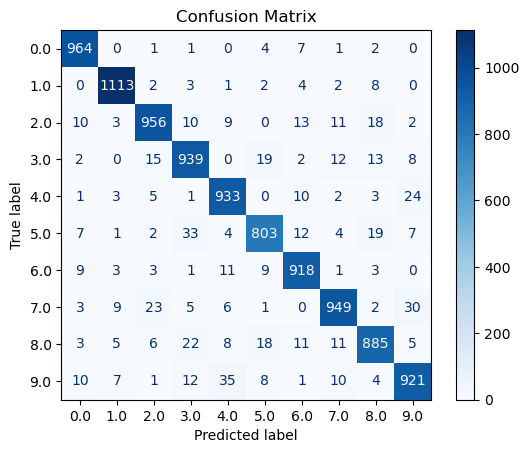

In [ ]:
def test():
    # insert code here
    softmax = torch.nn.Softmax(dim=1)
    model.eval()
    test_dataset = MNISTDataset("path_to_mnist_png", mode="testing")
    batch_size = 8
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    acc = 0
    gt = np.zeros(len(test_dataset)) #store all labels here
    preds = np.zeros(len(test_dataset)) #store all predictions here
    for i, (img, label) in tqdm(enumerate(test_dataloader)):
        with torch.no_grad():
            # insert code here

    acc /= len(test_dataset)
    print("Accuracy:", acc)
    # compute the confusion matrix here. Use confusion_matrix as well as ConfusionMatrixDisplay

    plt.title("Confusion Matrix")
    plt.show()
    return acc
acc = test()

**Task 8 (5pts):** Let us investigate the learning process when different learning rates are used. Modify the training such that the average loss of each epoch in saved. Afterwards plot the different losses with respect to the epochs for every learning rate. What do you see in the plot?

100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 65.58it/s]


Loss after epoch 0: 2.4097571690707826


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 67.95it/s]


Loss after epoch 1: 2.356880385230091


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 67.34it/s]


Loss after epoch 2: 2.3163748585593216


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.24it/s]


Loss after epoch 3: 2.2845850999929755


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 70.61it/s]


Loss after epoch 4: 2.2584269916070805


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.53it/s]


Loss after epoch 5: 2.2355335302698585


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.49it/s]


Loss after epoch 6: 2.2144143820317317


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 84.21it/s]


Loss after epoch 7: 2.194136749706797


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.58it/s]


Loss after epoch 8: 2.1741474292425713


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 67.52it/s]


Loss after epoch 9: 2.1542731340505927


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.01it/s]


Loss after epoch 0: 1.5273740207716855


100%|████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.13it/s]


Loss after epoch 1: 0.7519356964874878


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.10it/s]


Loss after epoch 2: 0.5026244100794863


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.92it/s]


Loss after epoch 3: 0.3939506306863034


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.94it/s]


Loss after epoch 4: 0.3347940558055316


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.90it/s]


Loss after epoch 5: 0.296762030389009


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.54it/s]


Loss after epoch 6: 0.269431716780355


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.82it/s]


Loss after epoch 7: 0.2480138941868536


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.65it/s]


Loss after epoch 8: 0.229897789188476


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.57it/s]


Loss after epoch 9: 0.21434679398658688


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.05it/s]


Loss after epoch 0: 3.4341747567597736


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 124.49it/s]


Loss after epoch 1: 3.192950797487678


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 124.56it/s]


Loss after epoch 2: 3.1555674426845397


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.13it/s]


Loss after epoch 3: 3.2485593435352547


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.69it/s]


Loss after epoch 4: 3.3009514455347935


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 125.07it/s]


Loss after epoch 5: 3.1621717862737206


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 124.66it/s]


Loss after epoch 6: 3.350392617396454


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 110.02it/s]


Loss after epoch 7: 3.1669949377015203


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 123.14it/s]


Loss after epoch 8: 3.1552722385443097


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 110.37it/s]


Loss after epoch 9: 3.2238937301168056


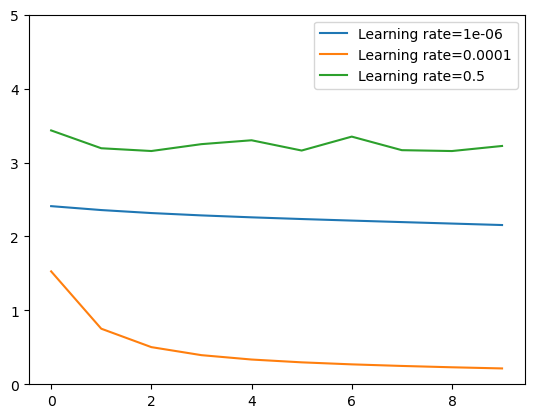

In [ ]:
def train(epochs, model, train_dataloader, optimizer, criterion):
    # insert code here



learning_rates = [0.000001, 0.0001, 0.5]
epochs = np.arange(0,10)
losses = {}
for lr in learning_rates:
    #insert code here to save the the losses calculated by train()
    model = MNISTModel(28*28, 10)
    model.apply(initialize_model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses[lr] = #insert code here


# plot the different losses with respect to the epochs for every learning rate with matplotlib.pylplot
# insert code here


**Task 9 (5pts):** Now plot the different losses with respect to the epochs for different optimizers used. What do you see and explain the differences of the three different optimizers.

100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 136.63it/s]


Loss after epoch 0: 2.4779584148545255


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 135.92it/s]


Loss after epoch 1: 2.4138559850294197


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 135.76it/s]


Loss after epoch 2: 2.3728734366675175


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.45it/s]


Loss after epoch 3: 2.3453094692372565


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.98it/s]


Loss after epoch 4: 2.3261043400144272


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.89it/s]


Loss after epoch 5: 2.3122137228308963


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.78it/s]


Loss after epoch 6: 2.3019695706458996


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.55it/s]


Loss after epoch 7: 2.2941130191278356


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.39it/s]


Loss after epoch 8: 2.2879085278968567


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 133.71it/s]


Loss after epoch 9: 2.2828126906840276


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 132.73it/s]


Loss after epoch 0: 2.2140318681436306


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 132.84it/s]


Loss after epoch 1: 1.7995583740378749


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 132.51it/s]


Loss after epoch 2: 1.2842870924645649


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 132.42it/s]


Loss after epoch 3: 0.9344607928414335


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 132.52it/s]


Loss after epoch 4: 0.7364845207886401


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 132.55it/s]


Loss after epoch 5: 0.61746729481449


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 132.14it/s]


Loss after epoch 6: 0.5410318652005084


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 132.29it/s]


Loss after epoch 7: 0.48876459321487686


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 131.72it/s]


Loss after epoch 8: 0.4517736293232517


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 130.96it/s]


Loss after epoch 9: 0.423916543168681


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 128.50it/s]


Loss after epoch 0: 1.572842613974614


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.20it/s]


Loss after epoch 1: 0.7536629834599586


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 128.37it/s]


Loss after epoch 2: 0.49549363904606814


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.11it/s]


Loss after epoch 3: 0.38768792652816914


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 128.26it/s]


Loss after epoch 4: 0.3306285202948015


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.04it/s]


Loss after epoch 5: 0.2945159691800949


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.73it/s]


Loss after epoch 6: 0.268552039811479


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.77it/s]


Loss after epoch 7: 0.24779619824594018


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.86it/s]


Loss after epoch 8: 0.23050992760751673


100%|███████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 127.98it/s]

Loss after epoch 9: 0.21569524812641175


[]

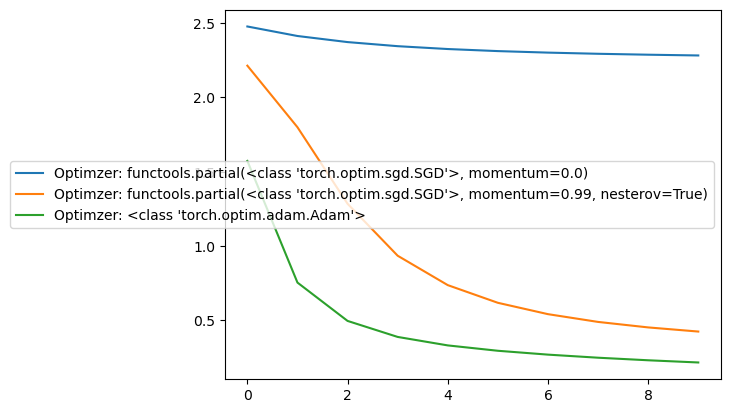

In [ ]:
optim = [partial(torch.optim.SGD, momentum=0.0), partial(torch.optim.SGD, momentum=0.99, nesterov=True), torch.optim.Adam]
epochs = np.arange(0,10)
losses = {}
for i,o in enumerate(optim):
    model = MNISTModel(28*28, 10)
    model.apply(initialize_model)
    optimizer = #insert code here
    losses[i] = #insert code here

#plot the losses with respect to the different optimizers

**Task 10 (5pts):** Why do we need a activation function like
- __relu__
- __tanh__
- __sigmoid__
  
between two layers in a neural network?
What happens if we do not use any of them? Therefore look at the computation inside the i-th layer and pass the activation $a_i$ to the next layer ${i+1}$:

$$a_{i} = W_{i} \cdot a_{i-1} + b_{i}$$

# insert explanation here